C:\Users\kaasa\AppData\Local\Temp\ipykernel_27316\2248668836.py:133: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  bicubic_upscale = transforms.Resize((img_height * 4, img_width * 4), interpolation=Image.BICUBIC)(img)


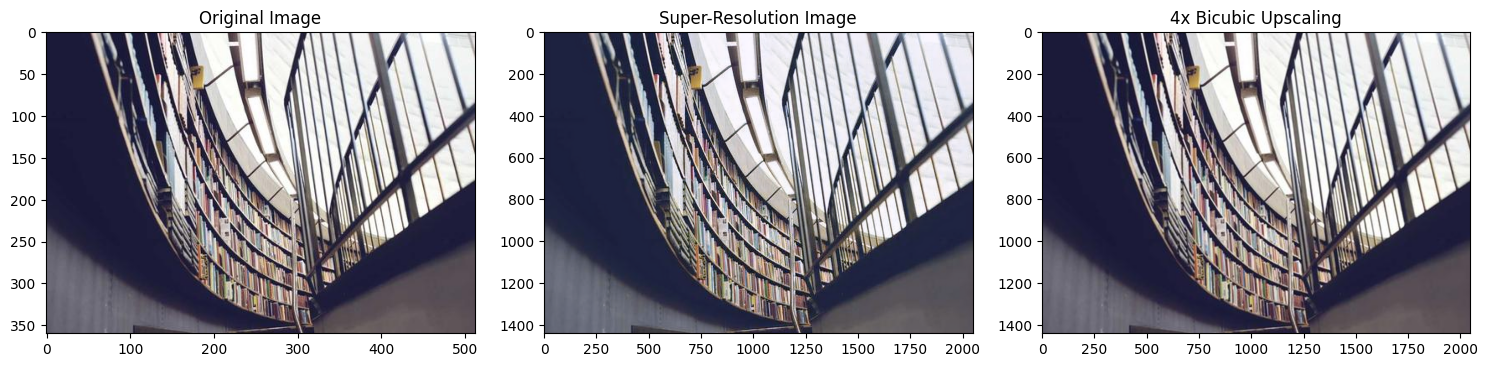

Images saved in the 'test_2' folder.


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import config
import numpy as np
import os

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))


class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x


class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)
    


# Load the pre-trained Generator model
model = Generator()
checkpoint = torch.load("gen.pth", map_location="cuda")
model.load_state_dict(checkpoint["state_dict"])
model.to("cuda")
model.eval()

img_height = 360
img_width =  512
# Download a random image from the internet
url = f'https://picsum.photos/{img_width}/{img_height}'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

#img = Image.open("test_images/baboon_LR.png").convert("RGB")

# Apply the test transform to the input image
input_image = config.test_transform(image=np.asarray(img))["image"].unsqueeze(0).to("cuda")

# Generate the super-resolution image
with torch.no_grad():
    upscaled_img = model(input_image)

# Convert the upscaled image tensor to a PIL image
upscaled_img = upscaled_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
upscaled_img = (upscaled_img * 255.0).clip(0, 255).astype('uint8')
upscaled_img = Image.fromarray(upscaled_img)

# Perform 4x bicubic upscaling for comparison
bicubic_upscale = transforms.Resize((img_height * 4, img_width * 4), interpolation=Image.BICUBIC)(img)

# Plot the original image, super-resolution image, and bicubic upscaling
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(upscaled_img)
axs[1].set_title('Super-Resolution Image')
axs[2].imshow(bicubic_upscale)
axs[2].set_title('4x Bicubic Upscaling')

plt.tight_layout()
plt.show()


# Create the test folder if it doesn't exist
test_folder = "test_1"
if os.path.exists(test_folder):
    test_folder = "test_2"
os.makedirs(test_folder, exist_ok=True)

# Save the images in the test folder
img.save(os.path.join(test_folder, "original_image.png"))
upscaled_img.save(os.path.join(test_folder, "super_resolution_image.png"))
bicubic_upscale.save(os.path.join(test_folder, "bicubic_upscale_image.png"))

print(f"Images saved in the '{test_folder}' folder.")